# Problem Statement

The task of this Course is to classify handwritten digits.

![Classifying Handwritten digits](https://www.wolfram.com/mathematica/new-in-10/enhanced-image-processing/HTMLImages.en/handwritten-digits-classification/smallthumb_10.gif)


## About the MNIST dataset

It is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. 


## Fetching the data

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

### Structure of Datasets loaded by Scikit Learn

Datasets loaded by Sklearn have a dictionary structure. They have the following keys :

1. A DESCR key describing the dataset
1. A data key containing an array with one row per instance and one column per feature
1. A target key containing an array with the labels


### Looking into the Datasets

The datasets consists of 70,000 images and each image has 784 features. A image consists of 28x28 pixels, and each pixel is a value from 0 to 255 describing the pixel intensity. 0 for white and 255 for black.


![MNIST dataset image](https://www.cntk.ai/jup/cntk103a_MNIST_input.png)

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

This is label for each of the image. Since there are 70,000 images, hence there are 70,000 labels.

### Looking at one of the datasamples

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

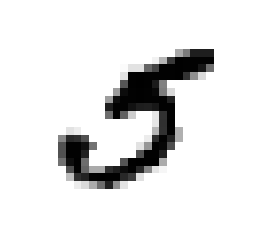

In [5]:
some_digit = X[36000]   # Selecting the 36,000th image.
some_digit_image = some_digit.reshape(28, 28) # Reshaping it to get the 28x28 pixels
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

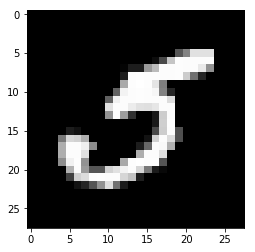

In [6]:
plt.imshow(255-some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")

The image looks like a 5. Let's verify it.

In [7]:
some_digit_image.shape

(28, 28)

In [8]:
X[36000].shape

(784,)

In [9]:
y[36000]

5.0

## Test train split

The MNIST dataset is split into a training set (the first 60,000 images) and a test set (the last 10,000 images)


In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


Also we need to **shuffle** our training data so that it ensures that we don't miss out any digit in a cross validation fold.

In [11]:
import numpy as np
np.random.seed(42)
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Classifying our Digits

### Training a Binary Classifier
Simplify problem and make a model that only predicts if the digit is 5 or not. This will be a example of a "Binary Classifier".

I'll create a target vector for the classification.

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Started with a **Stochastic Gradient Descent (SGD)** classifier, using **Scikit-Learn’s SGDClassifier class**. This classifier has the advantage of being
capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning).

Now, for binary classification '5' and 'Not 5', we train the SGD Classifier on the training dataset.

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=10) # if you want reproducible results set the random_state value.
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=10, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

### Testing using sample data

In [14]:
sgd_clf.predict([X[36000]])

array([ True])

In [15]:
y[36000]

5.0

## Measuring the performace of our Classifier

________
+ **Measuring Accuracy Using Cross-Validation**
______________
Used the cross_val_score() function to evaluate the **SGDClassifier model** using **K-fold cross-
validation**, with three folds. **K-fold cross-validation** means splitting the training set into K-folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds.

![A 10 fold cross validation](https://sebastianraschka.com/images/faq/evaluate-a-model/k-fold.png)

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=10, scoring="accuracy") 
# Since we need 3 folds hence we will set sv to 3

array([0.96417264, 0.96166667, 0.96866667, 0.96433333, 0.95116667,
       0.9675    , 0.9655    , 0.953     , 0.95066667, 0.96266044])

This an accuracy for all the 3 folds which is above 95% , which is a good accuracy. Accuracy is generally not the preferred performance measure for classifiers, especially when dealing with skewed datasets.

**What is a Skewed dataset ?**
When some classes are much more frequent than others, then the dataset is said to be skewed.

To verify the fact that accuracy is not best for Skewed dataset. In our case only 10% of the data is 5 so its a skewed dataset. If a classifier always predicts 5 than its accuracy is 90%. Lets see it in action.

In [17]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
never_5_pred = never_5_clf.predict(X_train)

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.909  , 0.90715, 0.9128 ])

So in this case the accuracy is above 90%. **Hence a better measure of performace is needed for the classifier.**

____________
+ **Measuring performace using a Confusion Matrix**
____________

A much better way to evaluate the performance of a classifier is to look at the **confusion matrix**. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but i'm keeping it untouched for now.

In [18]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation,
but instead of returning the evaluation scores, it returns the predictions made on each test fold

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53606,   973],
       [ 1607,  3814]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

The first row of this matrix considers non-5 images (the negative class):

 + 53,606 of them were correctly classified as non-5s (they are called true negatives)
 + The remaining 973 were wrongly classified as 5s (false positives). 
 
The second row considers the images of 5s (the positive class): 

+ 1,607 were wrongly classified as non-5s (false negatives)
+ The remaining 3,814 were correctly classified as 5s (true positives).

______________
+ **Measuring accuracy using Precision, Recall and F1 score**
________

![Formula for Precision and Recall](http://www2.isprs.org/tl_files/isprs/wg34/images/Precision_Recall_formula.png)

> **True - Positive**  means the classifier **correctly** classified the **Positive** class.

> **True - Negative**  means the classifier **correctly** classified the **Neative** class.

> **False - Positive**  means the classifier **incorrectly** classified a **Negative class** as **Positive Class.**

> **False - Negative**  means the classifier **incorrectly** classified a **Positive class** as **Negative Class.**


In [20]:
from sklearn.metrics import precision_score, recall_score

print ("Precision score is : " , precision_score(y_train_5, y_train_pred))
print ("Recall score is : " , recall_score(y_train_5, y_train_pred))

Precision score is :  0.7967411740129517
Recall score is :  0.7035602287400848


In [21]:
never_5_pred = never_5_pred.reshape(-1,)
print ("Precision score is : " , precision_score(y_train_5, never_5_pred))
print ("Recall score is : " , recall_score(y_train_5, never_5_pred))

Precision score is :  0.0
Recall score is :  0.0


/usr/local/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
from sklearn.base import BaseEstimator
class Always5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.ones((len(X), 1), dtype=bool)
    
always_5_clf = Always5Classifier()
always_5_pred = always_5_clf.predict(X_train)

always_5_pred = always_5_pred.reshape(-1,)
print ("Precision score is : " , precision_score(y_train_5, always_5_pred))
print ("Recall score is : " , recall_score(y_train_5, always_5_pred))


Precision score is :  0.09035
Recall score is :  1.0


It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of
precision and recall.


![F1 score](https://hassetukda.files.wordpress.com/2012/08/f12.jpg)

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7472570532915361

The F1 score favors classifiers that have similar precision and recall. **Increasing precision reduces recall, and vice versa.** *Raising the **threshold** decreases **Recall** *

In [24]:
sgd_clf.decision_function?

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([1206.46829305])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [27]:
# Setting the threshold to 20000
threshold = 20000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall.

**Precision - Recall curve**

In [28]:
cross_val_predict?

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")
len(y_scores)

60000

In [30]:
y_scores_1 = y_scores[:,1]

In [31]:
from sklearn.metrics import precision_recall_curve
precision_recall_curve(y_train_5, y_scores_1)

(array([0.09068402, 0.09066881, 0.09067032, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
        3.68935621e-04, 1.84467810e-04, 0.00000000e+00]),
 array([-987003.18242092, -983604.04486484, -983581.97688175, ...,
         546675.13288863,  552599.28731296,  644903.5324607 ]))

In [32]:
# Using these values of y_scores to find different values for precison and recall for varying thresholds.

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_1)


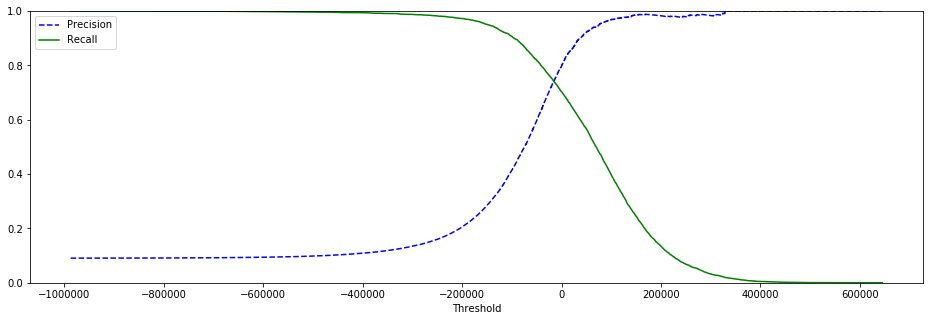

In [33]:
# Plotting the results

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(16,5))
    # Removing last value to avoid divide by zero in precision computation
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

We select the threshold value that gives best precision/recall tradeoff for your task.

Another way to select a good precision/recall tradeoff is to plot precision directly against recall directly.

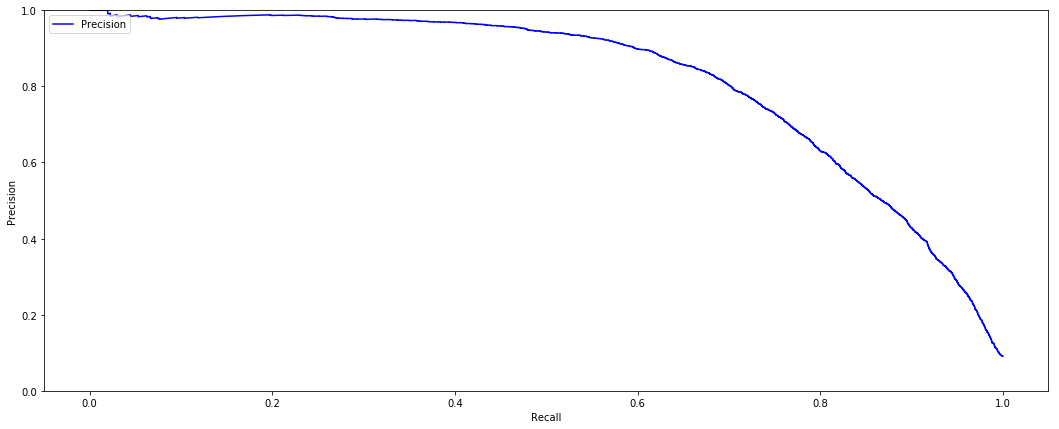

In [34]:
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(18,7))
    plt.plot(recalls[:-1], precisions[:-1], "b-", label="Precision")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_vs_recall(precisions, recalls)
plt.show()

**ROC curve**


> The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers.

> It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the **true positive rate (another name for recall)** against the **false positive rate**.

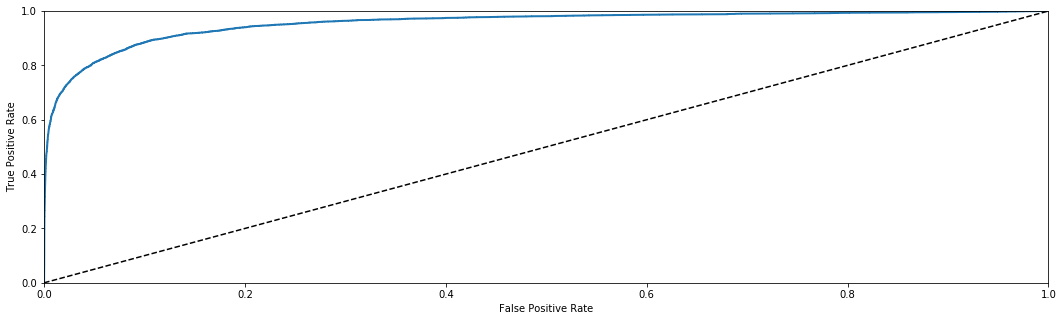

In [36]:
# Making the ROC curve


from sklearn.metrics import roc_curve

# y_scores_1 = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores[:, 1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(18,5))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: **the higher the recall (TPR), the more false positives (FPR) the classifier produces**. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).


One way to compare classifiers is to measure the **area under the curve (AUC)**. A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [40]:
# Scikit-Learn provides a function to compute the ROC AUC:

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores[:, 1])

0.9550544428458181

## Comparision of SGDClassifier and RandomForestClassifier on the basis of ROC-AUC

I trained a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier.

First, i got scores for each instance in the training set. But due to the way it works, the **RandomForestClassifier class** does not have a **decision_function()** method. Instead it has a **predict_proba()** method. Scikit-Learn classifiers generally have one or the other.

In [41]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest

array([[1. , 0. ],
       [0.9, 0.1],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

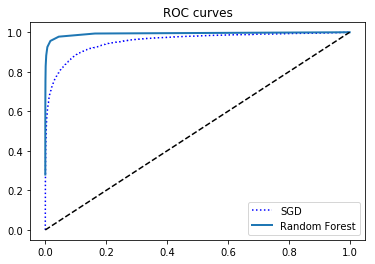

In [42]:
# To plot a ROC curve, you need scores, not probabilities.
# A simple solution is to use the positive class’s probability as the score:

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, "b:", label="SGD")
ax.plot(fpr_forest, tpr_forest, linewidth=2, label="Random Forest")
ax.plot([0, 1], [0, 1], 'k--')
ax.legend(loc=4);
ax.set_title('ROC curves');


The **RandomForestClassifier’s ROC curve** looks much better than the **SGDClassifier’s** as it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better.



In [48]:
# ROC auc score of SGDClassifier

from sklearn.metrics import roc_auc_score
print ("The ROC AUC value for SGDClassifier : ", roc_auc_score(y_train_5, y_scores[:, 1]))
print ("The ROC AUC value for Random Forest Classifier is : " , roc_auc_score(y_train_5, y_scores_forest))

The ROC AUC value for SGDClassifier :  0.9550544428458181
The ROC AUC value for Random Forest Classifier is :  0.9931243366003829


## Multiclass Classification


> Binary classifiers distinguish between two classes, **multiclass classifiers (also called multinomial classifiers)** can distinguish between more than two classes.

![Multiclass classification](https://raw.githubusercontent.com/ritchieng/machine-learning-stanford/master/w3_logistic_regression_regularization/multiclass_classification.png)

There are basically two strategies used for multiple binary classifiers for multiclass classification.

+ **One-versus-all (OvA) strategy also called one-versus-the-rest**

    For example, one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score.


+ **One-versus-one (OvO) strategy**

    This is another strategy in which we train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. If there are N classes, you need to train N × (N – 1) / 2 classifiers.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO).

In [57]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [62]:
y_train[1000]

8.0

In [61]:
some_digit_scores = sgd_clf.decision_function([X_train[1000]])
some_digit_scores

array([[-330256.74131412, -408727.27252892,  -93759.48808581,
        -460978.05122121, -189552.87772983, -281278.72718979,
        -272451.01681648, -198320.5270848 ,   37284.63986995,
        -169374.51720389]])

In [47]:
# The highest score is indeed the one corresponding to class 5:
print ("The index of the maxmimum score is ", np.argmax(some_digit_scores))

The index of the maxmimum score is  5


**To force ScikitLearn to use one-versus-one or one-versus-all, you can use the OneVsOneClassifier or OneVsRestClassifier classes**

In [63]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=20))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [65]:
len(ovo_clf.estimators_)

45

**Evaluating the accuracy of SGDClassifier**


In [68]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.87312537,  0.84179209,  0.87318098])

Simply scaling the inputs increases accuracy to above 90%

In [72]:
100*(0.91196761-0.87312537)/0.87312537

4.4486440704385934

In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91196761,  0.91149557,  0.90843627])

## Error Analysis

I'll make the Confusion Matrix. For this I need predictions.

In [70]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5730,    2,   23,    8,   11,   43,   51,    8,   43,    4],
       [   1, 6472,   46,   25,    6,   45,    5,   12,  119,   11],
       [  47,   35, 5351,  101,   85,   24,   89,   53,  160,   13],
       [  47,   39,  136, 5359,    1,  223,   34,   54,  142,   96],
       [  14,   27,   40,   11, 5356,    8,   54,   33,   94,  205],
       [  65,   40,   36,  186,   68, 4610,  102,   32,  195,   87],
       [  30,   24,   45,    2,   45,   98, 5614,    5,   54,    1],
       [  25,   17,   74,   29,   54,   13,    6, 5798,   19,  230],
       [  45,  139,   68,  154,   10,  150,   57,   25, 5080,  123],
       [  39,   32,   30,   86,  167,   34,    2,  203,   88, 5268]])

It is often convenient to represent the confusion matrix using Matplotlib’s matshow() function.

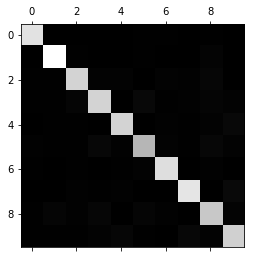

In [71]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Most images are on the main diagonal, which means that they were classified correctly.

** Calculating error rates instead of absoluter error and plotting **

I divided each value in the confusion matrix by the number of images in the corresponding class, so its easy to compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad). I performed the normalization and plotted the results again.

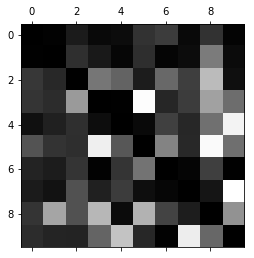

In [72]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Observations?

There are several observations that can be made using the above plotted graph and the potential remedies to the source of error can also be identified.

In [73]:
# EXTRA
import os
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

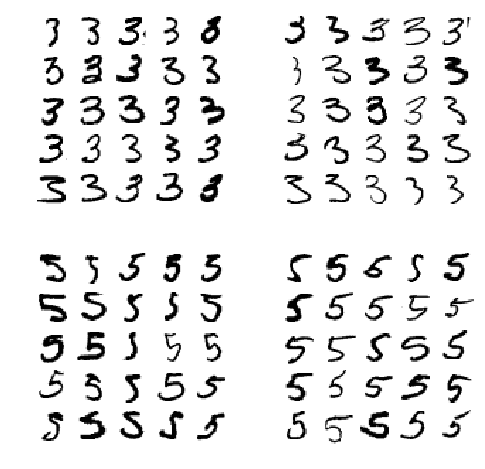

In [75]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


## Multilabel Classification

**Doing Multilabel Classification using Scikit Learn**

In [77]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]  # np.c_ is used to concatenate the two arrays element wise
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ..., 
       [False, False],
       [False, False],
       [ True,  True]], dtype=bool)

**y_multilabel** array containing two target labels for each digit image

+ the first indicates whether or not the digit is large (7, 8, or 9) 
+ and the second indicates whether or not it is odd. 

In [81]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

**KNeighborsClassifier** supports **multilabel classification** but not all classifiers do.

In [82]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

Since the digit 5 is indeed not large (False) and odd (True).

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on the project.

Here I used F1 score as a example.

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="weighted")

## Multioutput Classification

It is simply a generalization of multilabel classification where each label can be **multiclass (i.e., it can have more than two possible values).**


Here i built a system that removes noise from images. It will take as input a noisy digit image, and it will output a clean digit image, represented as an array of pixel intensities, just like the MNIST images.

Notice that the classifier’s output is **multilabel (one label per pixel)** and each label can have **multiple values (pixel intensity ranges from 0 to 255)**. It is thus an example of a **multioutput classification system.**

To do this I added noise to the MNIST dataset. I did this by generating random integer using **randint()** and adding to original image.

In [10]:
import numpy.random as rnd

noise_train = rnd.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise_train
noise_test = rnd.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test

Let's view the noisy image

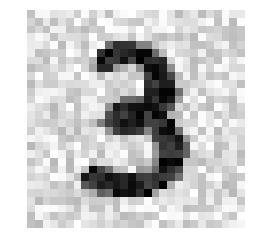

In [11]:
def plot_digit(array):
    array_image = array.reshape(28, 28)
    plt.imshow(array_image, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()
    
plot_digit(X_test_mod[4000])

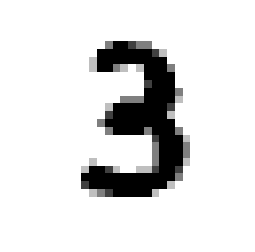

In [12]:
plot_digit(y_test_mod[4000])

Now we will clean the image using KNN classifier. It is a example of Multioutput classification. A single label is Multilabel as it has 784 classes and each of the 784 pixel can have values from 0 to 255, hence it is a Multioutput classification example.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

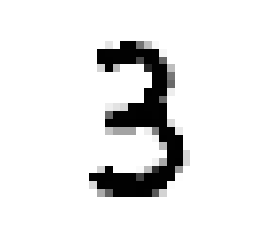

In [15]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[4000]])
plot_digit(clean_digit)

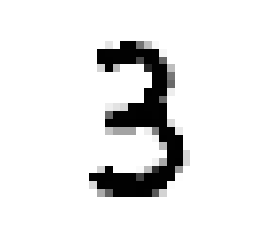

In [89]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[4000]])
plot_digit(clean_digit)

In [17]:
knn_clf.kneighbors_graph()

<60000x60000 sparse matrix of type '<class 'numpy.float64'>'
	with 300000 stored elements in Compressed Sparse Row format>